In [41]:
import argparse
import traceback
import time
import shutil
import logging
import yaml
import sys
import numpy as np
import copy
import os, glob, pickle

from PIL import Image

import matplotlib.pyplot as plt

import cv2


%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# folderOne = "AutomotiveProperAlignment1"
# folderOne = "Every10SimultaneousMethod"
folderOne = "DGXDataLiDARGenSettings/Circle/image_samples/images"
# folderOne = "AutomotiveAllForOne3"
# folderTwo = "AutomotiveFixedAttempt2"
# folderTwo = "AutomotiveAllForOneControlled4"
folderTwo = ""
# folderTwo = "DGXData/CircleTestingOhShitOnlyDidFullCircle"

In [42]:


loadLocation = folderOne
# loadLocation2 = folderTwo
allFiles = glob.glob(os.path.join(loadLocation, '*GT_image_grid_897.png'))
# exampleFile = allFiles[0]
# exampleFile = exampleFile.split('/')[-1]
# allFileNums = []
# allSettingNums = []
# for tempFile in allFiles:
#     tempFile = tempFile.split('/')[-1]
#     plzSplit = tempFile.split('_')[0]
#     plzSplit2 = tempFile.split('_')[1]
#     allFileNums.append(int(plzSplit2))
#     allSettingNums.append(int(plzSplit))
largestFileNum = len(allFileNums)
smallestFileNum = 0
largestSettingNum = 6
smallestSettingNum = 0
print("argest is")
print(largestFileNum)
print(smallestFileNum)

batchNum = 42
actualBatchNum = 7
#force it to work
# largestSettingNum = actualBatchNum
# largestSettingNum = 4

batchMod = batchNum // actualBatchNum
totalDistanceError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalPixels = np.zeros(actualBatchNum)
totalInputPixels = np.zeros(actualBatchNum)
totalOriginDistances = np.zeros(actualBatchNum)

#For varying 
# full_list = glob.glob(os.path.join(loadLocation, '*GT_completion_897.pth.npy'))
# largestFileNum = len(full_list) - 1
# smallestFileNum = 0
# totalNS_error = np.zeros(actualBatchNum)
time_list = glob.glob(os.path.join(loadLocation, '*0_*__TimeTaken.npy'))
timeArray = []
for time in time_list:
    timeArray.append(np.load(time).astype(float))
sortIndices = np.argsort(np.array(timeArray)).astype(int)
# print(sortIndices)
# print(sortIndices.shape)
# print(time_list.shape)
sortedList = np.array(time_list)[sortIndices]
# totalTELEA_error_intensity = np.zeros(actualBatchNum)
totalNS_error = np.zeros(actualBatchNum)
totalNS_error_intensity = np.zeros(actualBatchNum)
totalINTER_CUBIC_error = np.zeros(actualBatchNum)
totalINTER_NEAREST_error = np.zeros(actualBatchNum)
totalINTER_LINEAR_error = np.zeros(actualBatchNum)
totalINTER_CUBIC_error_intensity = np.zeros(actualBatchNum)
totalINTER_NEAREST_error_intensity = np.zeros(actualBatchNum)
totalINTER_LINEAR_error_intensity = np.zeros(actualBatchNum)
nearestStackDist = []
nearestStackInt = []
lidargenStackDist = []
gtStackDist = []
inputStackDist = []
for file_num in range(largestFileNum - smallestFileNum + 1):
# for file_num in range(1):
    channelNum = 2 * batchNum
    file_num = file_num + smallestFileNum
    print("FILE NUM IS")
    print(file_num)
    # if(file_num != 4):
    #     continue
    file_name = sortedList[file_num]
    print(file_name)
    file_name = file_name.split('/')[-1][1:-15]
    print(file_name)
    if(os.path.isfile(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy') == False):
        print(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy')
        print("does note xist")
        continue
    GTPath = loadLocation + '/' + str(0) + file_name + '__GT_completion_897.pth.npy'
    InputPath = loadLocation + '/' + str(0)  + file_name + '__Input_completion_897.pth.npy'
    # GTPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_GT_completion_897.pth.npy'
    # InputPath = loadLocation + '/' + str(0)  + '_' + str(file_num) + '_Input_completion_897.pth.npy'
    GT = np.reshape(np.load(GTPath)[:,0],(channelNum,64,1024))
    # GT = np.where(GT > 1, 0, GT)
    # np.clip(GT,0.0001,1)
    Input = np.reshape(np.load(InputPath)[:,0],(channelNum,64,1024))
    # Input = np.where(Input >= 1, 0, Input)
    # np.clip(Input,0.0001,1)
    # print(np.sum(GT))
    # print(np.sum(Input))
    GTdistance = GT[:batchNum]
    loggedIgnore = 0.1
    # loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
    GTdistance = np.power(2,GTdistance*6)-1
    # GTdistance = np.clip(GTdistance,0.0001,2000)
    # GTdistance = np.where(GTdistance == 2000, 0.0001,GTdistance)
    mask = np.logical_and(Input[:batchNum] <= 0.001, GTdistance > loggedIgnore)
    # mask = GTdistance <= loggedIgnore
    # mask = Input[:batchNum] >= 0.001
    #If I just want to compare ALL points and... see what happens?
    mask = np.ones_like(mask)
    # mask[:,0:10] = 0
    # mask = np.logical_and(GTdistance > 0.5, GTdistance < 63)
    # mask = Input[:batchNum] <= 0.001
    # mask = base_mask
    # mask = np.logical_not(mask)
    inputMask = np.logical_and(Input[:batchNum] > 0.1, GTdistance < 63)
    print("MASK SHAPE")
    print(mask.shape)
    print("TRUE SAN CHECK")
    print(np.sum(Input[0][inputMask[0]] - GT[0][inputMask[0]]))
    print(np.sum(Input[0] == GT[0]))
    for multiplier in range(batchNum // actualBatchNum):
        for j in range(actualBatchNum):
            k = actualBatchNum*multiplier + j
            totalPixels[j] += np.sum(mask[k])
            totalInputPixels[j] += np.sum(inputMask[k])
    GTintensity = GT[batchNum:]
    # print(GT.shape)
    # print(Input.shape)
    # GTdistance = np.where(mask,GTdistance,0)
    # GTintensity =np.where(mask,GTintensity,0)
    InputDist = np.float32(Input[:batchNum])
    InputIntensity = np.float32(Input[batchNum:])
    InputDist = np.power(2,InputDist*6)-1
    gtStackDist.append(GTdistance)
    # tempInputdistance = np.power(2,InputDist*6)-1
    tempInputdistance = InputDist
    inputStackDist.append(tempInputdistance)


    for multiplier in range(batchNum // actualBatchNum):
        for subSample in range(actualBatchNum):
                sample = actualBatchNum * multiplier + subSample
                fullSample = actualBatchNum * multiplier + subSample
                DensificationMask = np.zeros_like(InputDist[sample])
                DensificationMask[3::4] = 1
                DensificationMask[1::4] = 1
                DensificationMask[2::4] = 1
                NS_Result_temp = cv2.inpaint(InputDist[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=0)
                # TELEA_Result_temp = cv2.inpaint(InputDist[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)
                NS_Result_int = cv2.inpaint(InputIntensity[sample],(InputIntensity[sample] <= loggedIgnore).astype(np.uint8),3, flags=0)
                # TELEA_Result_int = cv2.inpaint(InputIntensity[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)

                print("SANITY CHECK TIME")
                print(GTdistance[fullSample][3::4].shape)

                # INTER_NEAREST_Result_temp = cv2.resize(InputDist[fullSample][3::4],(0, 0), (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                # INTER_NEAREST_Result_int = cv2.resize(InputIntensity[fullSample][3::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                # INTER_CUBIC_Result_temp = cv2.resize(InputDist[fullSample][3::4],(0, 0), (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                # INTER_CUBIC_Result_int = cv2.resize(InputIntensity[fullSample][3::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
            
                INTER_NEAREST_Result_temp = cv2.resize(GTdistance[fullSample][0::4],(0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                INTER_NEAREST_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
                INTER_CUBIC_Result_temp = cv2.resize(GTdistance[fullSample][0::4],(0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                INTER_CUBIC_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_CUBIC)
                 
                INTER_LINEAR_Result_temp = cv2.resize(GTdistance[fullSample][0::4],(0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_LINEAR)
                INTER_LINEAR_Result_int = cv2.resize(GTintensity[fullSample][0::4], (0, 0), fx=1.0, fy=4.0, interpolation=cv2.INTER_LINEAR)

                nearestStackDist.append(INTER_NEAREST_Result_temp)
                nearestStackInt.append(INTER_NEAREST_Result_int)
            
                # NS_Result_temp = np.clip(NS_Result_temp,0,1)
                # NS_Result_temp = np.power(2,NS_Result_temp*6)-1
                # NS_Result_int = np.clip(NS_Result_int,0,1)

                # INTER_NEAREST_Result_temp = np.clip(INTER_NEAREST_Result_temp,0.0001,2000)
                # INTER_NEAREST_Result_temp = np.power(2,INTER_NEAREST_Result_temp*6)-1
                # INTER_NEAREST_Result_int = np.clip(INTER_NEAREST_Result_int,0,1)

                # INTER_CUBIC_Result_temp = np.clip(INTER_CUBIC_Result_temp,0.0001,2000)
                # INTER_CUBIC_Result_temp = np.power(2,INTER_CUBIC_Result_temp*6)-1
                # INTER_CUBIC_Result_int = np.clip(INTER_CUBIC_Result_int,0,1)
                # TELEA_Result_temp = np.clip(TELEA_Result_temp,0,1)
                # TELEA_Result_int = np.clip(TELEA_Result_int,0,1)
                # TELEA_Result_temp = np.power(2,TELEA_Result_temp*6)-1
                # print("sanity check")
                # print(np.sum(InputIntensity[sample] > 1))
                # print(np.sum(TELEA_Result_int > 1))
                # print(np.sum(NS_Result_int > 1))
                # print(np.sum(GTintensity > 1))
                      
                
                # totalTELEA_error[subSample] += np.sum(np.absolute(TELEA_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalNS_error[subSample] += np.sum(np.absolute(NS_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                # totalTELEA_error_intensity[subSample] += np.sum(np.absolute(TELEA_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
                totalNS_error_intensity[subSample] += np.sum(np.absolute(NS_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )

    
                totalINTER_CUBIC_error[subSample] += np.sum(np.absolute(INTER_CUBIC_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalINTER_CUBIC_error_intensity[subSample] += np.sum(np.absolute(INTER_CUBIC_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
            
                totalINTER_NEAREST_error[subSample] += np.sum(np.absolute(INTER_NEAREST_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalINTER_NEAREST_error_intensity[subSample] += np.sum(np.absolute(INTER_NEAREST_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
            
                totalINTER_LINEAR_error[subSample] += np.sum(np.absolute(INTER_LINEAR_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
                totalINTER_LINEAR_error_intensity[subSample] += np.sum(np.absolute(INTER_LINEAR_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )

    #Get the distance between origins
    toWorld = np.squeeze(np.load(loadLocation + "/toWorld"+ file_name + "_.npy"))
    fromWorld = np.squeeze(np.load(loadLocation + "/fromWorld"+ file_name + "_.npy"))
    baseLine = np.array([0,0,0,1])
    origins = np.matmul(toWorld, baseLine)
    initialOrigin = np.matmul(np.linalg.inv(fromWorld), baseLine)
    print(np.absolute(origins - initialOrigin))
    origins = origins - initialOrigin
    origins = np.absolute(origins[:,:3])
    distances = np.sqrt(origins[:,0]*origins[:,0] + origins[:,1]*origins[:,1] + origins[:,2]*origins[:,2])
    print("yessssssss")
    # print(distances)
    distances = np.reshape(distances, (batchNum//actualBatchNum, actualBatchNum))
    totalOriginDistances += np.sum(distances, 0)
    # print(totalOriginDistances)

    for setting_num in range(largestSettingNum+1):
        loadNum = setting_num + smallestSettingNum
        maskedPath = loadLocation +'/' + str(loadNum) + file_name + '__Masked_completion_897.pth.npy'
        # if(setting_num >= actualBatchNum - 2):
        #     loadNum = setting_num + smallestSettingNum - 5
        #     maskedPath = loadLocation2 +'/' + str(loadNum) + file_name + '__Masked_completion_897.pth.npy'
            
        print(maskedPath)
        numberOfOutputs = (setting_num + 2)
        if(numberOfOutputs > actualBatchNum):
            numberOfOutputs = actualBatchNum 
        if(setting_num == actualBatchNum - 1):
            numberOfOutputs = 1
        actualChannelNum = numberOfOutputs*batchMod * 2
        # print("NUMBER OF FUCKING INPUTS")
        # print(numberOfInputs)
        # print(largestSettingNum)
        # print("setting")
        # print(setting_num)
        # mask = base_mask[:actualChannelNum]
        # inputMask = inputMask_base[:actualChannelNum]
        # sharedPath = loadLocation +'/' + str(setting_num) + '_' + str(file_num) + '_Masked_Shared_completion_897.pth.npy'
        prediction = np.reshape(np.load(maskedPath)[:,0],(actualChannelNum,64,1024))
        # print(np.mean(prediction[:batchNum][mask]))
        # prediction = np.where(prediction >= 1, 0, prediction) 
        # np.clip(prediction,0,1)
        # print(np.mean(prediction))
        #no project back up
        distance = prediction[:actualChannelNum//2]
        # print(np.mean(distance))
        distance = np.power(2,distance*6)-1
        # print(np.mean(distance))
        intensity = prediction[actualChannelNum//2:]
        # print("mean is")
        # print(np.mean(distance[mask]))
        
        # distance = np.where(mask,distance,0)
        # intensity =np.where(mask,intensity,0)
        # print(np.mean(distance))
        for multiplier in range(batchNum // actualBatchNum):
            for subSample in range(numberOfOutputs):
                sample = numberOfOutputs * multiplier + subSample
                fullSample = actualBatchNum * multiplier + subSample
                # print(sample)
                # print(sample)
                distanceError = np.sum(np.absolute(distance[sample][mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )#/ GTdistance[sample][mask[sample]])
                intensityError = np.sum(np.absolute(intensity[sample][mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )#/ GTintensity[sample][mask[sample]])
                distanceErrorInput = np.sum(np.absolute(distance[sample][inputMask[fullSample]] - GTdistance[fullSample][inputMask[fullSample]]) )#/ GTdistance[sample][mask[sample]])
                intensityErrorInput = np.sum(np.absolute(intensity[sample][inputMask[fullSample]] - GTintensity[fullSample][inputMask[fullSample]]) )#/ GTintensity[sample][mask[sample]])
                # print("before")
                # print(totalDistanceErrorInput)
                totalDistanceError[setting_num,subSample] += distanceError
                totalIntensityError[setting_num,subSample] += intensityError
                totalDistanceErrorInput[setting_num,subSample] += distanceErrorInput
                totalIntensityErrorInput[setting_num,subSample] += intensityErrorInput
                totalDistanceInput[setting_num,subSample] += np.sum(distance[sample][inputMask[fullSample]])
                # print(distanceErrorInput)
                # print("after")
                # print(totalDistanceErrorInput )

        # plt.imshow(mask[5])
        # plt.axis('off')
        # plt.show()
        # plt.imshow(np.absolute(GTdistance[5] - distance[5]))
        # plt.axis('off')
        # plt.show()
        # plt.imshow(distance[5])
        # plt.axis('off')
        # plt.show()

totalOriginDistances = totalOriginDistances / ((largestFileNum - smallestFileNum + 1)*batchMod)
print(totalDistanceErrorInput)

argest is
4
0
FILE NUM IS
0
DGXDataLiDARGenSettings/Circle/image_samples/images/6_6143_6183_3542_8510_3375_6935__TimeTaken.npy
_6143_6183_3542_8510_3375_6935
MASK SHAPE
(42, 64, 1024)
TRUE SAN CHECK
1806.1901782846644
23
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 1024)
SANITY CHECK TIME
(16, 10

In [43]:
distanceAcc = (totalNS_error) / (totalPixels+0.000001)
intensityAcc = (totalNS_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_NEAREST_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_NEAREST_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_CUBIC_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_CUBIC_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

distanceAcc = (totalINTER_LINEAR_error) / (totalPixels+0.000001)
intensityAcc = (totalINTER_LINEAR_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

[ 3.0991069   5.16909283  5.14258139  4.78122116  8.8684593  11.77494603
  6.02089525]
[0.17736422 0.24843057 0.24763447 0.2407387  0.24849159 0.22746183
 0.25539359]
[1.96609472 2.08758102 2.02738316 2.16655026 1.83361444 1.77769526
 2.2849344 ]
[0.09782624 0.08277537 0.07275471 0.08078356 0.0530916  0.05289393
 0.07714724]
[2.27211068 2.44820677 2.39330281 2.52897888 2.16917362 2.08228929
 2.71543849]
[0.10971731 0.09515715 0.08374961 0.09199018 0.06120297 0.06078726
 0.08922675]
[2.10101063 2.24587347 2.19729403 2.32503989 1.99170973 1.91825936
 2.49276174]
[0.10389448 0.08920512 0.07839562 0.08654233 0.05706858 0.05680698
 0.0834258 ]


In [195]:

# totalTELEA_error = np.zeros(actualBatchNum)
# totalNS_error = np.zeros(actualBatchNum)
# totalTELEA_error_intensity = np.zeros(actualBatchNum)
# totalNS_error_intensity = np.zeros(actualBatchNum)
# for file_num in range(largestFileNum - smallestFileNum+1):
#     if(file_num != largestFileNum - smallestFileNum):
#         continue
#     channelNum = 2 * batchNum
#     file_num = file_num + smallestFileNum
#     # if(file_num != 4):
#     #     continue
#     file_name = full_list[file_num]
#     file_name = file_name.split('/')[-1][1:-27]
#     if(os.path.isfile(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy') == False):
#         print(loadLocation +'/' + str(largestSettingNum) + file_name + '__Masked_completion_897.pth.npy')
#         print("does note xist")
#         continue
#     GTPath = loadLocation + '/' + str(0) + file_name + '__GT_completion_897.pth.npy'
#     InputPath = loadLocation + '/' + str(0) + file_name + '__Input_completion_897.pth.npy'
#     GT = np.reshape(np.load(GTPath)[:,0],(channelNum,64,1024))
#     GT = np.where(GT >= 1, 0, GT) 
#     loggedIgnore = 0.1
#     loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
#     Input = np.reshape(np.load(InputPath)[:,0],(channelNum,64,1024))
#     Input = np.where(Input >= 1, 0, Input)
        
    
    
#     # print(np.sum(GT))
#     # print(np.sum(Input))
                
#     GTdistance = GT[:batchNum]
#     mask = np.logical_and(Input[:batchNum] <= 0.001, GTdistance > loggedIgnore)
#     # mask = base_mask
#     inputMask = np.logical_and(Input[:batchNum] > 0.001, GTdistance > loggedIgnore)
#     print("MASK SHAPE")
#     print(mask.shape)
#     # for multiplier in range(batchNum // actualBatchNum):
#     #     for j in range(actualBatchNum):
#     #         k = actualBatchNum*multiplier + j
#     #         totalPixels[j] += np.sum(mask[k])
#     GTdistance = np.power(2,GTdistance*6)-1
#     GTintensity = GT[batchNum:]
#     InputDist = np.float32(Input[:batchNum])
#     InputIntensity = np.float32(Input[batchNum:])
#     # InputDist = np.power(2,InputDist*6)-1
#     NSResultStack = []
#     NSIntStack = []

#     for multiplier in range(batchNum // actualBatchNum):
#         for subSample in range(actualBatchNum):
#                 sample = actualBatchNum * multiplier + subSample
#                 fullSample = actualBatchNum * multiplier + subSample
#                 NS_Result_temp = cv2.inpaint(InputDist[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=0)
#                 # TELEA_Result_temp = cv2.inpaint(InputDist[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)
#                 NS_Result_int = cv2.inpaint(InputIntensity[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=0)
#                 # TELEA_Result_int = cv2.inpaint(InputIntensity[sample],(InputDist[sample] <= loggedIgnore).astype(np.uint8),3, flags=1)
#                 NS_Result_temp = np.clip(NS_Result_temp,0,1)
#                 NS_Result_temp = np.power(2,NS_Result_temp*6)-1
#                 # TELEA_Result_temp = np.clip(TELEA_Result_temp,0,1)
#                 # TELEA_Result_temp = np.power(2,TELEA_Result_temp*6)-1
#                 print("sanity check")
#                 print(np.sum(InputIntensity[sample] > 1))
#                 # print(np.sum(TELEA_Result_int > 1))
#                 print(np.sum(NS_Result_int > 1))
#                 # print(np.sum(GTintensity > 1))
#                 NSResultStack.append(NS_Result_temp)
#                 NSIntStack.append(NS_Result_int)
                      
                
#                 # totalTELEA_error[subSample] += np.sum(np.absolute(TELEA_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
#                 totalNS_error[subSample] += np.sum(np.absolute(NS_Result_temp[mask[fullSample]] - GTdistance[fullSample][mask[fullSample]]) )
#                 # totalTELEA_error_intensity[subSample] += np.sum(np.absolute(TELEA_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )
#                 totalNS_error_intensity[subSample] += np.sum(np.absolute(NS_Result_int[mask[fullSample]] - GTintensity[fullSample][mask[fullSample]]) )

MASK SHAPE
(42, 64, 1024)
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
MASK SHAPE
(42, 64, 1024)
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check
0
0
sanity check


[20.38371715 22.28639076 23.44460671 24.00357521 24.64128773 25.02611514
 25.26097928]
[0.65597678 0.81899872 0.95016565 1.0496246  1.18736023 1.33023613
 1.48140007]
[1.44064855 1.59707269 1.77453693 1.96522466 2.20604383 2.57611044
 2.9938312 ]
[0.11719718 0.12644866 0.13281033 0.13756968 0.1484261  0.16223355
 0.17793519]


In [307]:

totalPixels = np.zeros(actualBatchNum)
for file_num in range(largestFileNum - smallestFileNum+1):
    channelNum = 2 * batchNum
    file_num = file_num + smallestFileNum
    # if(file_num != 4):
    #     continue
    file_name = full_list[file_num]
    file_name = file_name.split('/')[-1][1:-27]
    if(os.path.isfile(loadLocation +'/' + str(largestSettingNum-3) + file_name + '__Masked_completion_897.pth.npy') == False):
        print(loadLocation +'/' + str(largestSettingNum-3) + file_name + '__Masked_completion_897.pth.npy')
        print("does note xist")
        continue
    GTPath = loadLocation + '/' + str(0) + file_name + '__GT_completion_897.pth.npy'
    InputPath = loadLocation + '/' + str(0) + file_name + '__Input_completion_897.pth.npy'
    GT = np.reshape(np.load(GTPath)[:,0],(channelNum,64,1024))
    GT = np.where(GT >= 1, 0, GT) 
    loggedIgnore = 0.1
    loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
    Input = np.reshape(np.load(InputPath)[:,0],(channelNum,64,1024))
    Input = np.where(Input >= 1, 0, Input)
        
    
    
    # print(np.sum(GT))
    # print(np.sum(Input))
                
    GTdistance = GT[:batchNum]
    mask = np.logical_and(Input[:batchNum] <= 0.001, GTdistance > loggedIgnore)
    # mask = np.ones_like(mask)
    for multiplier in range(batchNum // actualBatchNum):
        for j in range(actualBatchNum):
            k = actualBatchNum*multiplier + j
            totalPixels[j] += np.sum(mask[k])

DGXData/FinalFullSetOfAblationTests/6_1293_1574_9293_8777_9837_4665__Masked_completion_897.pth.npy
does note xist


In [45]:
distanceAcc = (totalTELEA_error) / (totalPixels+0.000001)
intensityAcc = (totalTELEA_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)
distanceAcc = (totalNS_error) / (totalPixels+0.000001)
intensityAcc = (totalNS_error_intensity) / (totalPixels+0.000001)
print(distanceAcc)
print(intensityAcc)

[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[ 3.0991069   5.16909283  5.14258139  4.78122116  8.8684593  11.77494603
  6.02089525]
[0.17736422 0.24843057 0.24763447 0.2407387  0.24849159 0.22746183
 0.25539359]


In [293]:
print(totalPixels)
print(64*1024*2)

[ 832127. 1175712. 1386110. 1503841. 1581103. 1664079. 1717356.]
131072


In [44]:
print(totalPixels/((largestFileNum - smallestFileNum+1)*(batchMod)*64*1024))
print(totalOriginDistances)
print("Za Input")
print(largestFileNum)
#THIS IS WRONG
# totalInputPixels = ((largestFileNum - smallestFileNum+1)*64*1024)*(batchMod) - totalPixels
# print(totalDistanceInput / (totalInputPixels+0.000001))
print(totalInputPixels/((largestFileNum - smallestFileNum)*(batchMod)*64*1024))

# totalDistanceError = np.square(totalDistanceError)
for setting_num in range(largestSettingNum - smallestSettingNum+1):
    loadNum = setting_num + smallestSettingNum
    # distanceAcc = np.sum((totalDistanceError[setting_num])) / np.sum(totalPixels)
    # intensityAcc = np.sum((totalIntensityError[setting_num])) / np.sum(totalPixels)
    # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
    # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
    # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
    # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
    distanceAcc = (totalDistanceError[setting_num]) / (totalPixels+0.000001)
    intensityAcc = (totalIntensityError[setting_num]) / (totalPixels+0.000001)
    # distanceAcc = (totalDistanceError[setting_num][0]) / totalPixels[0]
    # intensityAcc = (totalIntensityError[setting_num][0]) / totalPixels[0]
    # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
    # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
    
    distanceAccInput = (totalDistanceErrorInput[setting_num]) / (totalInputPixels+0.000001)
    intensityAccInput = (totalIntensityErrorInput[setting_num]) / (totalInputPixels+0.000001)
    print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))
    # if(setting_num == largestSettingNum - smallestSettingNum ):
    print("Input: " + str(loadNum) + " Distance is: " + str(distanceAccInput) + " Intensity is : " + str(intensityAccInput))
print("comparing the pair")
# improvement = (totalDistanceError[0][1:] - totalDistanceError[1][1:]) / totalDistanceError[0][1:] 
# print(improvement)
# if(folderTwo != ""):
#     for setting_num in range(largestSettingNum2 - smallestSettingNum2+1):
#         loadNum = setting_num + smallestSettingNum2
#         # distanceAcc = np.sum((totalDistanceError2[setting_num])) / np.sum(totalPixels2)
#         # intensityAcc = np.sum((totalIntensityError2[setting_num])) / np.sum(totalPixels2)
#         # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
#         # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
#         distanceAcc = (totalDistanceError[setting_num]) / totalPixels
#         intensityAcc = (totalIntensityError[setting_num]) / totalPixels
#         # distanceAcc = (totalDistanceError2[setting_num][5:]) / totalPixels2[5:]
#         # intensityAcc = (totalIntensityError2[setting_num][5:]) / totalPixels2[5:]
#         # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
#         # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
#         print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))

# print("comparing the pair")
# # improvement = (totalDistanceError[0][5:] - totalDistanceError[1][5:]) / totalDistanceError[0][5:] 
# print(improvement)

[1. 1. 1. 1. 1. 1. 1.]
[8.66733828 8.66733828 8.66733828 8.66733828 8.66733828 8.66733828
 8.66733828]
Za Input
4
[0.45755386 0.28410339 0.46767044 0.37606494 0.32919502 0.14837392
 0.7839756 ]
Setting: 0 Distance is: [2.94623137 4.82980244 0.         0.         0.         0.
 0.        ] Intensity is : [0.15420326 0.20594285 0.         0.         0.         0.
 0.        ]
Input: 0 Distance is: [2.31376426 4.57548862 0.         0.         0.         0.
 0.        ] Intensity is : [0.16799483 0.20567069 0.         0.         0.         0.
 0.        ]
Setting: 1 Distance is: [2.94445427 4.87152578 4.7864561  0.         0.         0.
 0.        ] Intensity is : [0.15320065 0.20602631 0.20021787 0.         0.         0.
 0.        ]
Input: 1 Distance is: [2.31376426 4.57548862 4.68137614 0.         0.         0.
 0.        ] Intensity is : [0.16799483 0.20567069 0.21347367 0.         0.         0.
 0.        ]
Setting: 2 Distance is: [2.95514079 4.96434143 4.81834937 4.53157494 0.       

11208.0
8201.271
3493.054
51418
65536
0.10841930533714757
original


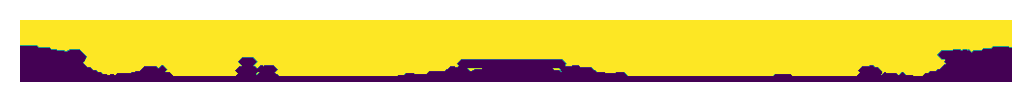

In [338]:
existVals = np.load("existTotalBackup.npy")
import scipy

import matplotlib.pyplot as plt
print(np.max(existVals))
mean =np.mean(existVals)
std = np.std(existVals)
print(np.mean(existVals))
print(np.std(existVals))
max = np.max(existVals)
existVals = existVals > mean - (std*2)
# existVals = existVals > 0
existVals[2:] = scipy.ndimage.binary_erosion(existVals[2:], border_value = 1, iterations=4)
print(np.sum(existVals > 0))
print(np.sum(existVals > -500))
# existVals[:15] = scipy.ndimage.binary_closing(existVals[:15], border_value = 1, iterations=3)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)
1
print((mean - (std*2))/max)
%matplotlib inline

plt.rcParams['figure.dpi'] = 200
print("original")

plt.imshow(existVals)
plt.axis('off')
plt.show()

(64, 1024)
huhhhh


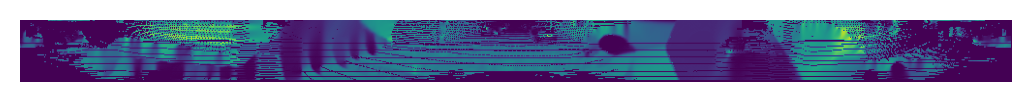

In [245]:
%matplotlib inline

plt.rcParams['figure.dpi'] = 200
print(NSResultStack[-1].shape)
plt.axis('off')
print("huhhhh")
temp = np.where(mask[-2],NSIntStack[-2], 0)
plt.imshow(temp)

huh


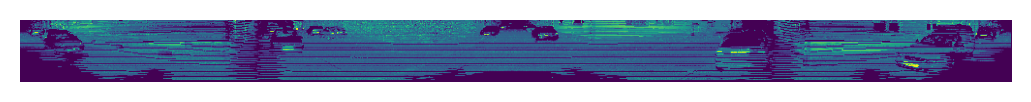

In [243]:

print("huh")
plt.imshow(GTintensity[-2])
plt.axis('off')
plt.show()

huh


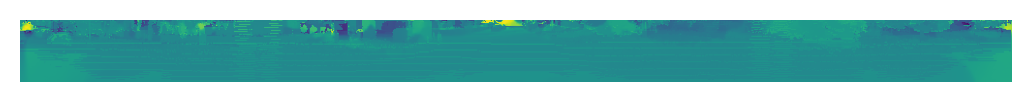

4.416867296856196

In [233]:
print("huh")
plt.imshow(NSIntStack[1] - GTdistance[0])
plt.axis('off')
plt.show()
np.mean(np.absolute(NSResultStack[7][mask[7]] - GTdistance[7][mask[7]]))

In [225]:
GTdistance.shape
mask.shape

(42, 64, 1024)

In [255]:
np.stack(NSResultStack).shape

(42, 64, 1024)

In [277]:
a = np.sum(np.absolute(np.stack(NSResultStack)[0][mask[0]] - GTdistance[0][mask[0]])) 
b = np.sum(np.absolute(np.stack(NSResultStack)[7][mask[7]] - GTdistance[7][mask[7]])) 
c = np.sum(np.absolute(np.stack(NSResultStack)[14][mask[14]] - GTdistance[14][mask[14]]))  
d = np.sum(np.absolute(np.stack(NSResultStack)[21][mask[21]] - GTdistance[21][mask[21]]))  
e = np.sum(np.absolute(np.stack(NSResultStack)[28][mask[28]] - GTdistance[28][mask[28]]))  
f = np.sum(np.absolute(np.stack(NSResultStack)[35][mask[35]] - GTdistance[35][mask[35]]))

In [280]:
totalDistanceError[5]

array([248839.27839934, 326711.97460936, 405557.88246613, 477800.74694571,
       595343.29973854, 692969.47168752, 796900.81352751])

In [278]:
a + b + c + d + e + f

176800.78606500028

In [357]:
import torch

input = torch.load("TheirMethodProperly/densify_samples_result.pth").detach().cpu().numpy()
target = torch.load("TheirMethodProperly/densify_samples_target.pth").detach().cpu().numpy()

In [358]:
input.shape

(8, 2, 64, 1024)

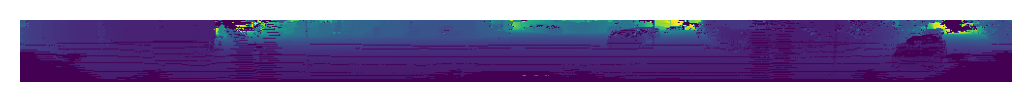

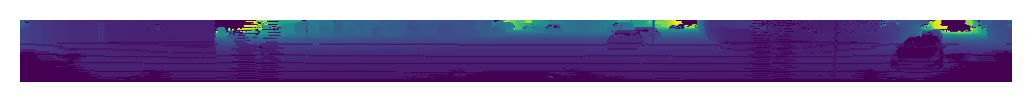

In [366]:
plt.imshow(np.power(2,6*input[0,0])-1)
plt.axis('off')
plt.show()

plt.imshow(np.power(2,6*target[0,0])-1)
plt.axis('off')
plt.show()

In [362]:
np.min(input)

0.0